In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import csv
import random
import pandas as pd
import itertools
from sklearn.metrics import confusion_matrix as get_confusion_matrix


In [13]:
initialize_centroids = lambda data, k: data[np.random.choice(data.shape[0], k, replace=False), :]


groups_centroid = lambda data, centroids:np.argmin(
    np.sqrt(
        (
            (data - centroids[:, np.newaxis])**2
        ).sum(axis=2)
    )
    , axis=0)

move_centroids = lambda data, groups, centroids: np.array([
    data[groups==k].mean(axis=0) 
    for k in range(centroids.shape[0])
])

In [26]:
points = np.vstack(((np.random.randn(150, 2) * 0.75 + np.array([1, 0])),
                  (np.random.randn(50, 2) * 0.25 + np.array([-0.5, 0.5])),
                  (np.random.randn(50, 2) * 0.5 + np.array([-0.5, -0.5]))))


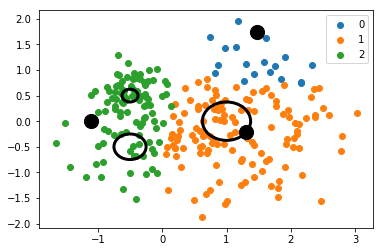

In [27]:

k =3
centroids = initialize_centroids(points, k)

groups = groups_centroid(points, centroids)
for i_k in range(k):
    is_by_group, colors = zip(*filter(lambda group: group[1]==i_k, enumerate(groups)))
    points_by_group = np.take(points,is_by_group, axis=0)
    plt.scatter(points_by_group[:, 0], points_by_group[:, 1])
    
plt.legend([str(i_k) for i_k in range(k)])
plt.scatter(centroids[:,0], centroids[:,1], marker="o", s=200, c="black", )

ax = plt.gca()
ax.add_artist(plt.Circle(np.array([1, 0]), 0.75/2, fill=False, lw=3))
ax.add_artist(plt.Circle(np.array([-0.5, 0.5]), 0.25/2, fill=False, lw=3))
ax.add_artist(plt.Circle(np.array([-0.5, -0.5]), 0.5/2, fill=False, lw=3))
plt.show()

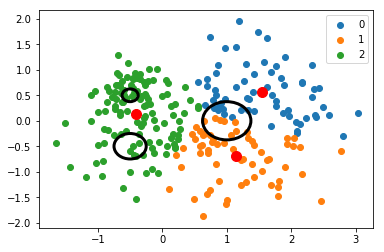

In [29]:
for i in range(100):
    groups = groups_centroid(points, centroids)

    #centroids= centroids +np.random.normal(scale=.05, size=(3,2))

    centroids = move_centroids(points, groups, centroids)
for i_k in range(k):
    is_by_group, colors = zip(*filter(lambda group: group[1]==i_k, enumerate(groups)))
    points_by_group = np.take(points,is_by_group, axis=0)
    plt.scatter(points_by_group[:, 0], points_by_group[:, 1])
    
plt.legend([str(i_k) for i_k in range(k)])

plt.scatter(centroids[:, 0], centroids[:, 1], c='r', s=100)



ax = plt.gca()
ax.add_artist(plt.Circle(np.array([1, 0]), 0.75/2, fill=False, lw=3))
ax.add_artist(plt.Circle(np.array([-0.5, 0.5]), 0.25/2, fill=False, lw=3))
ax.add_artist(plt.Circle(np.array([-0.5, -0.5]), 0.5/2, fill=False, lw=3))
plt.show()

## iris

In [30]:

def load_dataset(filename, train_size, y_col, features=None):
    with open(filename, 'r') as csvfile:
        lines = csv.reader(csvfile)
        x_train = []
        x_test = []
        y_train = []
        y_test = []
        for items in lines:
            
            if len(items)>1:
                y_val  = items[y_col]
                items.pop(y_col)
                if features is None:
                    items = np.array([float(item) for item in items])
                else:
                    items = np.array([float(items[i_feature]) for i_feature in features])
                if random.random() < train_size:
                    y_train.append(y_val)
                    x_train.append(items)
                else:
                    y_test.append(y_val)
                    x_test.append(items)
    return np.array(x_train), x_test, y_train, y_test

In [35]:

xs_train, xs_test, ys_train, ys_test = load_dataset(
            "iris.data.csv", 
            train_size=.4, 
            y_col=4,
            #features=[0,]
            )
# existem três classes
k =3
#número de iterações
n_iterations = 10
centroids = initialize_centroids(xs_train, k)
groups_database = np.unique(ys_train)

for i in range(n_iterations):
    groups = groups_centroid(xs_train, centroids)
    centroids = move_centroids(xs_train, groups, centroids)

max_confusion = None
max_matching = None
max_trace_matching = 0.
max_group_to_label={}

matching_list = []
for labels in itertools.permutations(range(k), k):
    
    group_to_label={}
    for i, l in enumerate(labels):
        group_to_label[l] = groups_database[i]
        
    ys_pred = [group_to_label[g] for g in groups]
    confusion = get_confusion_matrix(ys_train, ys_pred)
    matching = np.zeros_like(confusion ,dtype=np.float)
    for i, line in enumerate(confusion):
        z = np.sum(line)
        for j, col in enumerate(line):
            matching[i,j ] = float(col)/float(z)*100
            
    trace_matching = np.trace(matching)

    matching_list.append(matching)

    if trace_matching > max_trace_matching:
        max_confusion = confusion
        max_matching = matching
        max_trace_matching = trace_matching
        max_group_to_label = group_to_label


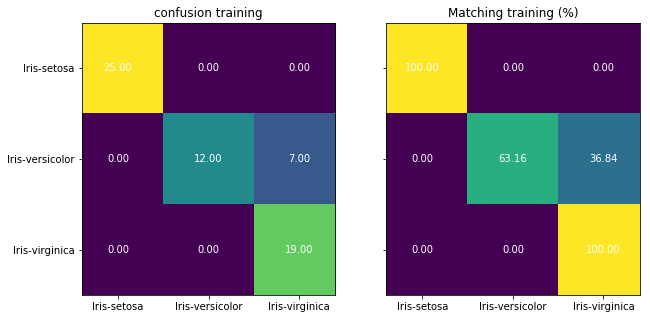

In [36]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

for title, data, ax in (
    ("confusion training", max_confusion, axes[0]),
    ("Matching training (%)", max_matching, axes[1])
):
    ax.set_title(title)
    ax.imshow(data)

    for x in range(k):
        for y in range(k):
            ax.annotate("{:.2f}".format(data[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        color="white",
                        verticalalignment='center')

    ax.set_xticks(range(k))
    ax.set_xticklabels(max_group_to_label.values())
    ax.set_yticks(range(k))
    ax.set_yticklabels(max_group_to_label.values())

plt.show()

In [37]:
#em relação aos dados de teste

groups_test = groups_centroid(xs_test, centroids)

ys_test_pred = [max_group_to_label[g] for g in groups_test]
confusion = get_confusion_matrix(ys_test, ys_test_pred)
matching = np.zeros_like(confusion ,dtype=np.float)
for i, line in enumerate(confusion):
    z = np.sum(line)
    for j, col in enumerate(line):
        matching[i,j ] = float(col)/float(z)*100



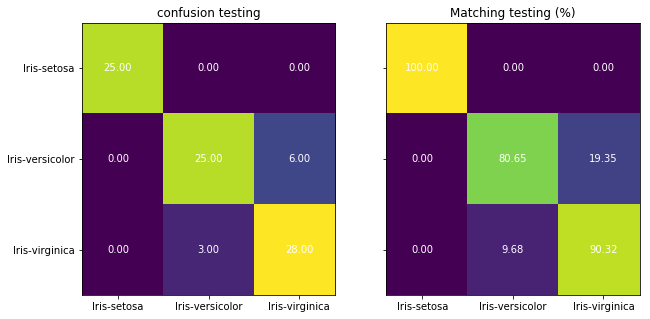

In [38]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

for title, data, ax in (
    ("confusion testing", confusion, axes[0]),
    ("Matching testing (%)", matching, axes[1])
):
    ax.set_title(title)
    ax.imshow(data)

    for x in range(k):
        for y in range(k):
            ax.annotate("{:.2f}".format(data[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        color="white",
                        verticalalignment='center')

    ax.set_xticks(range(k))
    ax.set_xticklabels(max_group_to_label.values())
    ax.set_yticks(range(k))
    ax.set_yticklabels(max_group_to_label.values())

plt.show()